In [1]:
! nvidia-smi

Fri Sep 20 20:04:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:3B:00.0 Off |                  Off |
| N/A   26C    P0              25W / 250W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from CGAN import CGAN

In [3]:
class ARGS:
    gan_type = "CGAN"
    dataset = "fashion-mnist"
    split = ""
    epoch = 50
    batch_size = 64
    input_size = 28
    save_dir = "models"
    result_dir = "results"
    log_dir = "logs"
    lrG = 0.0002
    lrD = 0.0002
    beta1 = 0.5
    beta2 = 0.999
    gpu_mode = True
    benchmark_mode = True


args = ARGS()

In [4]:
CGAN = CGAN(args)

---------- Networks architecture -------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6650433
discriminator(
  (conv): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [5]:
CGAN.load()

In [6]:
CGAN.G.eval()

generator(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)

In [7]:
import torch

sample_y1 = torch.zeros(int(1e6), CGAN.class_num).cuda()

In [8]:
import torch
import numpy as np
from tqdm.auto import tqdm

samples1 = np.zeros((int(1e6), 28*28))
samples2 = np.zeros((int(1e6), 28*28))
for i in tqdm(range(10)):
    sample_y1 = torch.zeros(int(1e5), CGAN.class_num).cuda()
    sample_y1[:, 0] = 1
    sample_z1 = torch.rand((int(1e5), CGAN.z_dim)).cuda()
    sample_y2 = torch.zeros(int(1e5), CGAN.class_num).cuda()
    sample_y2[:, 1] = 1
    sample_z2 = torch.rand((int(1e5), CGAN.z_dim)).cuda()
    samples1_ = CGAN.G(sample_z1, sample_y1).cpu().data.numpy().transpose(0, 2, 3, 1).reshape(-1, 28*28)
    samples1_ = (samples1_ + 1) / 2
    samples2_ = CGAN.G(sample_z2, sample_y2).cpu().data.numpy().transpose(0, 2, 3, 1).reshape(-1, 28*28)
    samples2_ = (samples2_ + 1) / 2
    samples1[i * int(1e5):(i + 1) * int(1e5)] = samples1_
    samples2[i * int(1e5):(i + 1) * int(1e5)] = samples2_
    del sample_z1, sample_z2, sample_y1, sample_y2, samples1_, samples2_

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
samples1.shape

(1000000, 784)

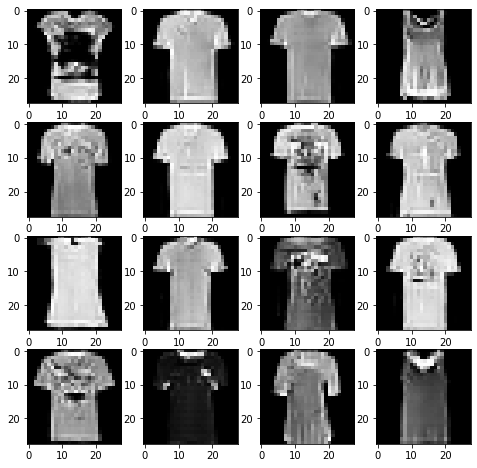

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples1[i].reshape(28, 28), cmap="gray")

In [11]:
mean1 = samples1.mean(axis=0, keepdims=True)
mean2 = samples2.mean(axis=0, keepdims=True)

samples1 = samples1 - mean1
samples2 = samples2 - mean2

In [12]:
S1 = samples1.T @ samples1 / len(samples1)
S2 = samples2.T @ samples2 / len(samples2)

In [13]:
np.trace(S1), np.trace(S2)

(39.17836452264903, 23.99771262267575)

In [14]:
trace_ratio = np.trace(S1) / np.trace(S2)

samples2 = np.sqrt(trace_ratio) * samples2

In [15]:
S1 = samples1.T @ samples1 / len(samples1)
S2 = samples2.T @ samples2 / len(samples2)

In [16]:
np.trace(S1), np.trace(S2)

(39.17836452264903, 39.17836452264903)

In [17]:
normS = np.linalg.norm((S1 + S2) /2, ord=2)
trS = np.trace((S1 + S2) / 2)

trS

39.17836452264903

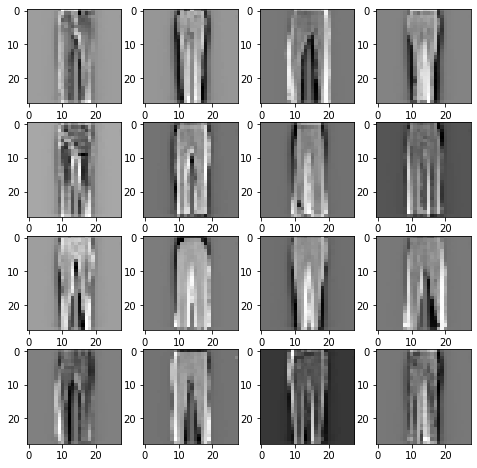

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples2[i].reshape(28, 28), cmap="gray")

In [19]:
import jax.numpy as jnp
import jax
import numpy as np

from jax import config

config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [20]:
jax.default_backend()

'gpu'

In [21]:
np.random.seed(0)

In [22]:
def generate_gaussian_feature_matrix(n, k, tr):
    return (1 / np.sqrt(tr)) * jnp.asarray(np.random.randn(k, n))

In [23]:
def ReLU(z):
    return jnp.maximum(z,0)

def tanh(z):
    return jnp.tanh(z)

def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))

def ReLU_prime(z):
    return jnp.where(z > 0, 1, 0)

def tanh_prime(z):
    return 1 - jnp.tanh(z)**2

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [24]:
def data_generator(m, theta_multiplier):
    global mean1, mean2, trace_ratio, normS, trS, CGAN
    if m / int(1e5) > 1:
        if m % int(1e5) > 0:
            ms = [int(1e5)] * int(m/int(1e5)) + [m % int(1e5)]
        else:
            ms = [int(1e5)] * int(m/int(1e5))
    else:
        ms = [m]
    X1 = np.zeros((m//2, 28*28))
    X2 = np.zeros((m//2, 28*28))
    for i, m_val in enumerate(ms):
        m1 = m_val // 2
        m2 = m_val - m1
        sample_y1 = torch.zeros(m1, CGAN.class_num).cuda()
        sample_y1[:, 0] = 1
        sample_z1 = torch.rand((m1, CGAN.z_dim)).cuda()
        sample_y2 = torch.zeros(m2, CGAN.class_num).cuda()
        sample_y2[:, 1] = 1
        sample_z2 = torch.rand((m2, CGAN.z_dim)).cuda()
        samples1_ = CGAN.G(sample_z1, sample_y1).cpu().data.numpy().transpose(0, 2, 3, 1).reshape(-1, 28*28)
        samples1_ = (samples1_ + 1) / 2
        samples2_ = CGAN.G(sample_z2, sample_y2).cpu().data.numpy().transpose(0, 2, 3, 1).reshape(-1, 28*28)
        samples2_ = (samples2_ + 1) / 2
        X1[i * int(5e4):(i + 1) * int(5e4)] = samples1_
        X2[i * int(5e4):(i + 1) * int(5e4)] = samples2_
        del sample_z1, sample_z2, sample_y1, sample_y2, samples1_, samples2_
    X1 = (X1 - mean1.reshape(1, 28*28))
    X2 = np.sqrt(trace_ratio) * (X2 - mean2.reshape(1, 28 * 28))
    X1 = jnp.asarray(X1)
    X2 = jnp.asarray(X2)
    X = jnp.concatenate([X1, X2], axis=0)
    X = np.sqrt(theta_multiplier / trS) * X + jnp.asarray(np.random.randn(*X.shape))
    y = jnp.concatenate([jnp.ones((m//2, 1)), -jnp.ones((m//2, 1))], axis=0)
    return X, y

In [25]:
def loss_calc(w, y, RF, lambd):
    return (1 / 2) * jnp.mean((y-RF.T @ w)**2) + (lambd / 2) * (jnp.linalg.norm(w) ** 2)

In [26]:
def least_square_estimator(y, RF, lambd):
    k, m = RF.shape
    w = jnp.linalg.solve(RF @ RF.T + lambd * m * jnp.eye(k), RF @ y)
    return w

In [27]:
n = 28*28
m = 500
lambd = 1e-4
delta = 0
NB_TRIALS = 20

In [28]:
from numpy.polynomial.hermite_e import hermeval

def Hermite(i, x):
    return jnp.asarray(hermeval(np.asarray(x), [0] * i + [1]))

def generate_Hermite_expansion(h, hs, b):
    act_func = lambda x: jnp.asarray(hermeval(np.asarray(x)/b, np.asarray(h))) + hs * jnp.asarray(np.random.randn(*x.shape))
    return act_func

In [29]:
from scipy.special import roots_hermitenorm

nodes, weights = roots_hermitenorm(100)
nodes = jnp.asarray(nodes)
weights = jnp.asarray(weights)

def calculate_expectation(func):
    # Expectation calculation with Gauss-Hermite quadrature
    return jnp.dot(weights, func(nodes)) / np.sqrt(2 * np.pi)

def calculate_h(activation, b):
    h = np.zeros(11)
    hs = np.zeros(11)
    h_var = calculate_expectation(lambda z: activation(b * z) ** 2)
    factorial = 1
    for i in range(11):
        h[i] = calculate_expectation(lambda z: Hermite(i, z) * activation(b * z))
        h_var = h_var - (1 / factorial) * (h[i] ** 2)
        h[i] = h[i] / factorial
        hs[i] = jnp.sqrt(h_var)
        factorial = factorial * (i + 1)
    return h, hs

In [30]:
import gc,sys

def clear_caches():
    for module_name, module in sys.modules.items():
        if module_name.startswith("jax"):
            if module_name not in ["jax.interpreters.partial_eval"]:
                for obj_name in dir(module):
                    obj = getattr(module, obj_name)
                    if hasattr(obj, "cache_clear"):
                        try:
                            obj.cache_clear()
                        except:
                            pass
    gc.collect()

In [31]:
beta = 1
alpha = 0

l = int(np.ceil(beta / (1 - beta + 1e-6)))
l = np.maximum(l, 1)  # Limiting the minimum number of Hermite polynomials is 1
l = np.minimum(l, 4) # Limiting the maximum number of Hermite polynomials to 4 for numerical stability

eta = np.power(n, beta * alpha)
theta_multiplier = np.power(n, beta * (1 - alpha))

dataF = data_generator(m, theta_multiplier)
data = data_generator(m, theta_multiplier)
data_new = data_generator(5*m, theta_multiplier)

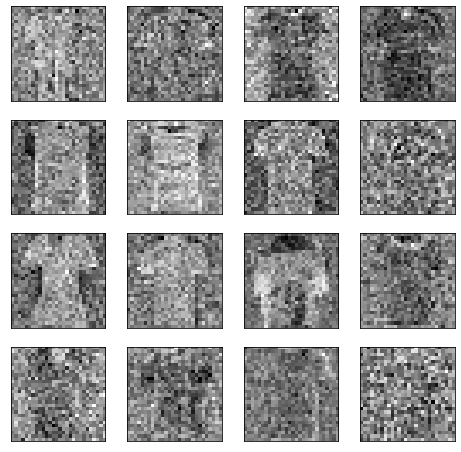

In [32]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(data[0][i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

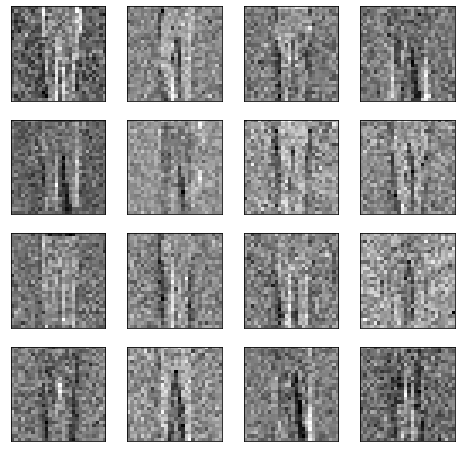

In [33]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(data[0][(m // 2) + i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [34]:
r_vals = [0.01, 0.1, 0.3, 0.4, 0.5, 0.7, 0.9, 1, 1.1, 1.5, 2, 3, 4, 5]

tr = n + theta_multiplier
b = 1 #np.sqrt(n / tr)

relu_h, relu_hs = calculate_h(ReLU, b)
tanh_h, tanh_hs = calculate_h(tanh, b)
sigmoid_h, sigmoid_hs = calculate_h(sigmoid, b)
relu_hermite = generate_Hermite_expansion(relu_h[:l+1], relu_hs[l], b)
tanh_hermite = generate_Hermite_expansion(tanh_h[:l+1], tanh_hs[l], b)
sigmoid_hermite = generate_Hermite_expansion(sigmoid_h[:l+1], sigmoid_hs[l], b)

relu_l_feature = np.zeros((len(r_vals), NB_TRIALS))
relu_gl_feature = np.zeros((len(r_vals), NB_TRIALS))
relu_l_hermite = np.zeros((len(r_vals), NB_TRIALS))
relu_gl_hermite = np.zeros((len(r_vals), NB_TRIALS))

tanh_l_feature = np.zeros((len(r_vals), NB_TRIALS))
tanh_gl_feature = np.zeros((len(r_vals), NB_TRIALS))
tanh_l_hermite = np.zeros((len(r_vals), NB_TRIALS))
tanh_gl_hermite = np.zeros((len(r_vals), NB_TRIALS))

sigmoid_l_feature = np.zeros((len(r_vals), NB_TRIALS))
sigmoid_gl_feature = np.zeros((len(r_vals), NB_TRIALS))
sigmoid_l_hermite = np.zeros((len(r_vals), NB_TRIALS))
sigmoid_gl_hermite = np.zeros((len(r_vals), NB_TRIALS))


def NN(w, F, dataF, data, data_new, activationF, activationF_derivative, activation, eta, lambd=lambd):
    k, n = F.shape
    X_tilde, y_tilde = dataF
    m_tilde = X_tilde.shape[0]
    FX_tilde = F @ X_tilde.T

    G = (1 / m_tilde) * ( (1/np.sqrt(k)) * (w @ (y_tilde.T - (1/np.sqrt(k)) * w.T @ activationF(FX_tilde))) * activationF_derivative(FX_tilde)) @ X_tilde
    F_hat = F + eta * G

    X, y = data
    X_new, y_new = data_new

    features = activation(F_hat @ X.T) / np.sqrt(k)
    features_new = activation(F_hat @ X_new.T) / np.sqrt(k)

    w_hat = least_square_estimator(y, features, lambd)
    loss_ = loss_calc(w_hat, y, features, lambd)
    gloss_ = loss_calc(w_hat, y_new, features_new, 0)

    return (loss_.item(), gloss_.item())

for e in tqdm(range(NB_TRIALS)):
    for r_i, r in enumerate(tqdm(r_vals)):
        k = int(m * r)

        F = generate_gaussian_feature_matrix(n, k, tr)
        w = jnp.asarray(np.random.randn(k, 1)) / np.sqrt(k)

        (
            relu_l_feature[r_i, e],
            relu_gl_feature[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            ReLU,
            ReLU_prime,
            ReLU,
            eta,
            lambd=lambd
        )

        (
            tanh_l_feature[r_i, e],
            tanh_gl_feature[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            tanh,
            tanh_prime,
            tanh,
            eta,
            lambd=lambd
        )

        (
            sigmoid_l_feature[r_i, e],
            sigmoid_gl_feature[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            sigmoid,
            sigmoid_prime,
            sigmoid,
            eta,
            lambd=lambd,
        )

        (
            relu_l_hermite[r_i, e],
            relu_gl_hermite[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            ReLU,
            ReLU_prime,
            relu_hermite,
            eta,
            lambd=lambd
        )

        (
            tanh_l_hermite[r_i, e],
            tanh_gl_hermite[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            tanh,
            tanh_prime,
            tanh_hermite,
            eta,
            lambd=lambd
        )

        (
            sigmoid_l_hermite[r_i, e],
            sigmoid_gl_hermite[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            sigmoid,
            sigmoid_prime,
            sigmoid_hermite,
            eta,
            lambd=lambd,
        )

        clear_caches()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [35]:
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

plt.style.use(["science", "bright"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Times"],
        "font.size": 10,
        "figure.dpi": "600",
    }
)

colors = ["#0072B2", "#E69F00", "#CC79A7"]

(0.0, 1.0)

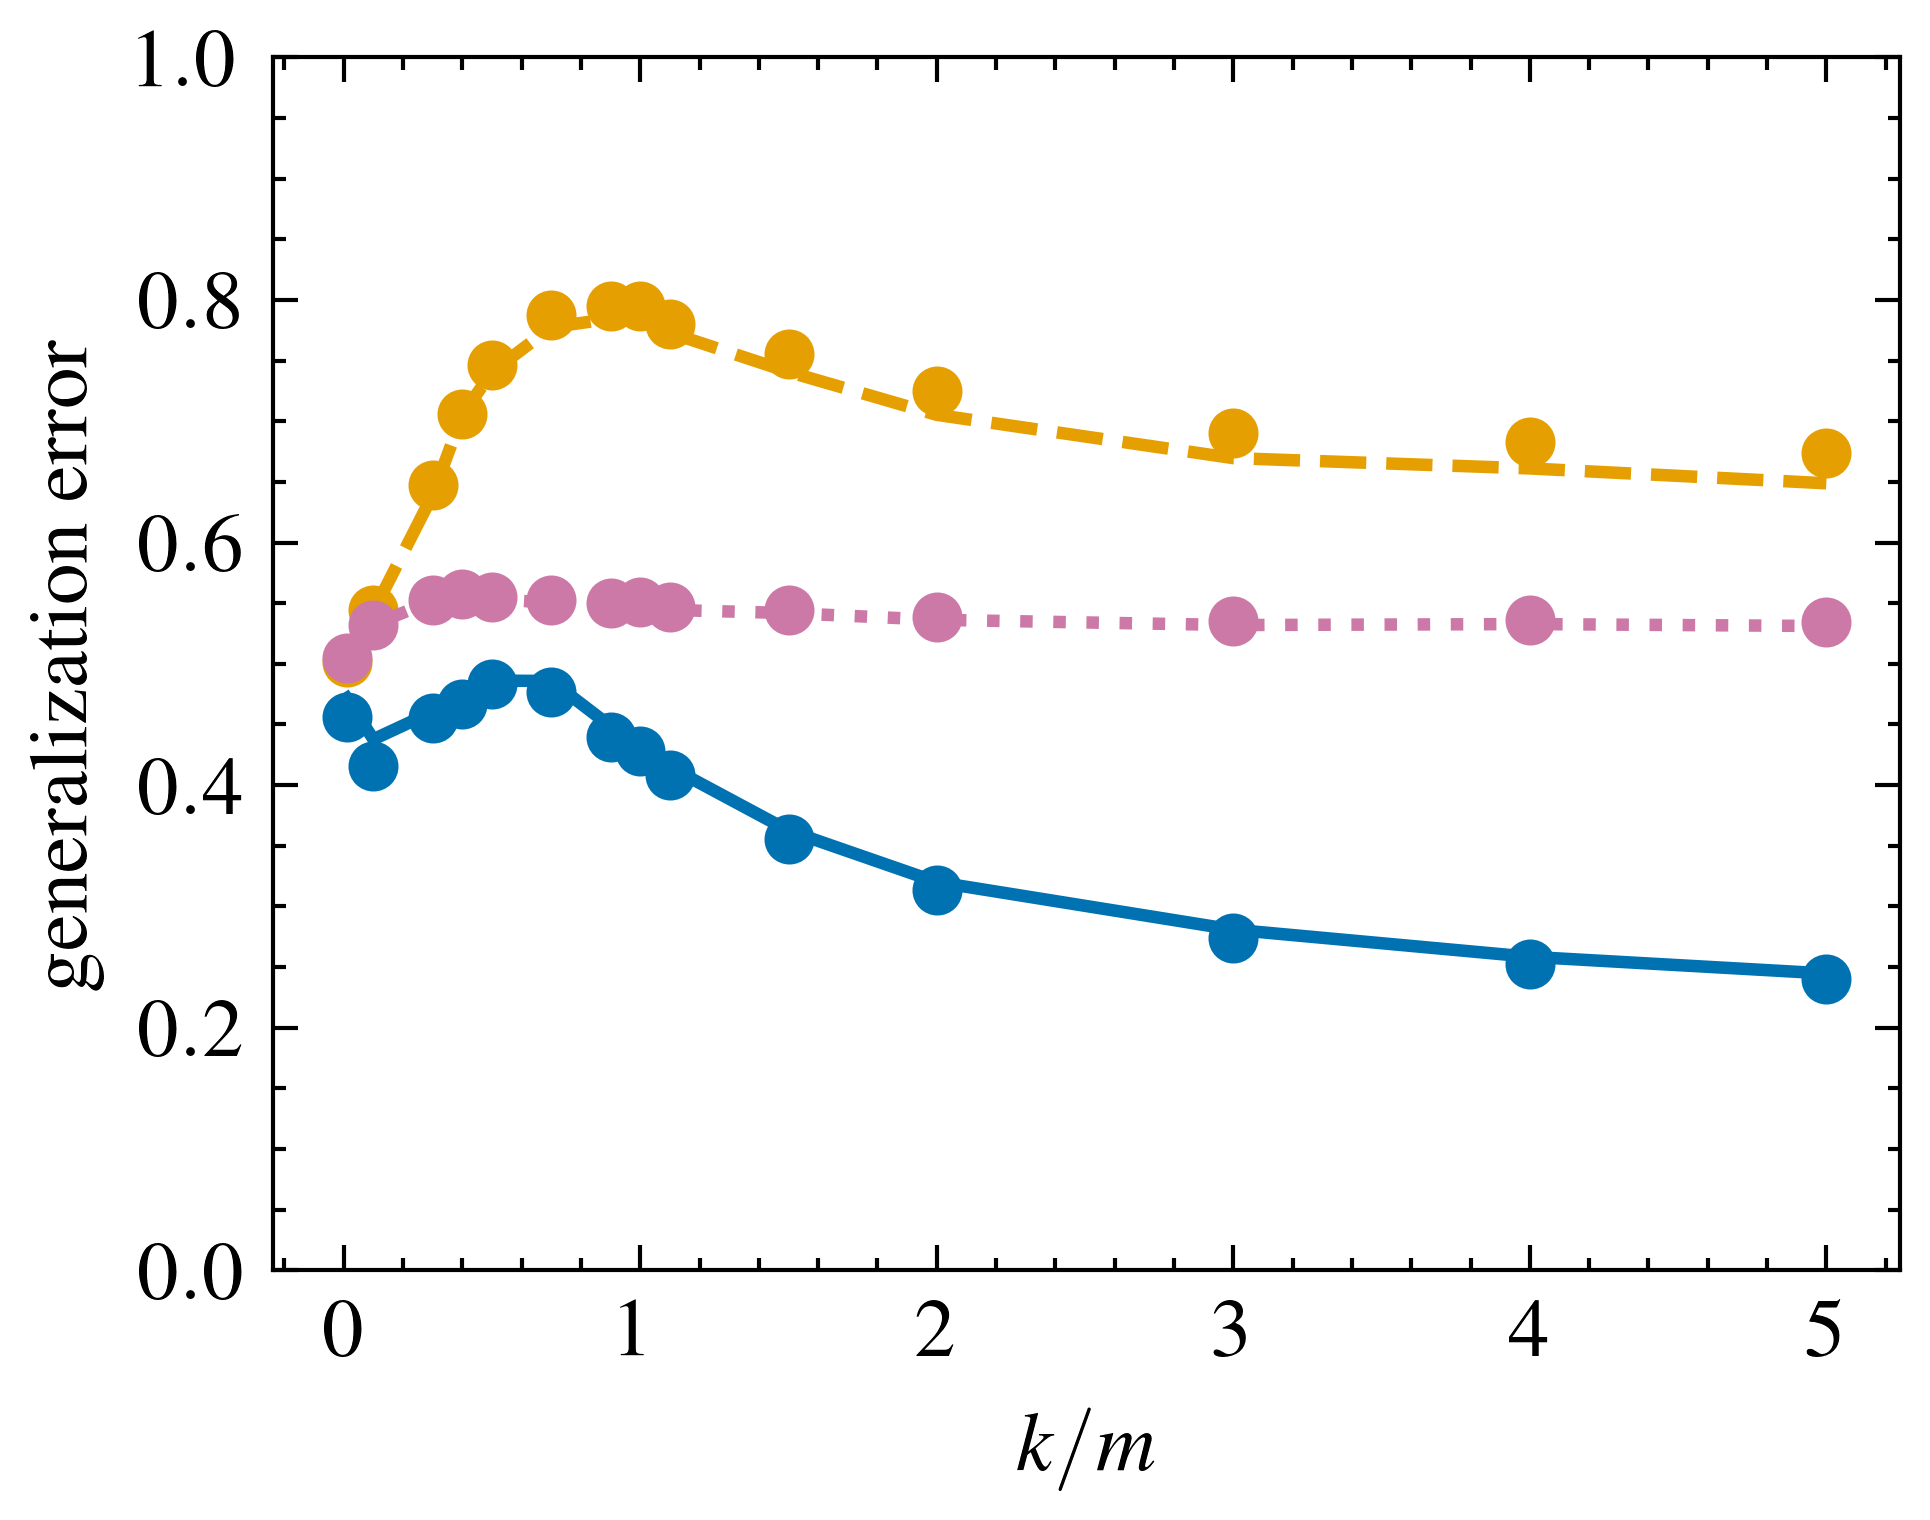

In [36]:
from matplotlib.legend_handler import HandlerTuple

plt.figure()
(relu_feature_gen,) = plt.plot(
    r_vals,
    np.mean(relu_gl_feature, axis=1),
    color=colors[0],
    linestyle="None",
    marker="o",
    markersize=5,
)

(relu_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(relu_gl_hermite, axis=1),
    color=colors[0],
    linestyle="solid",
    linewidth=1.5,
    label="ReLU",
)

(tanh_feature_gen,) = plt.plot(
    r_vals,
    np.mean(tanh_gl_feature, axis=1),
    color=colors[1],
    linestyle="None",
    marker="o",
    markersize=5,
)
(tanh_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(tanh_gl_hermite, axis=1),
    color=colors[1],
    linestyle="dashed",
    linewidth=1.5,
    label="tanh",
)

(sigmoid_feature_gen,) = plt.plot(
    r_vals,
    np.mean(sigmoid_gl_feature, axis=1),
    color=colors[2],
    linestyle="None",
    marker="o",
    markersize=5,
)

(sigmoid_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(sigmoid_gl_hermite, axis=1),
    color=colors[2],
    linestyle="dotted",
    linewidth=1.5,
    label="sigmoid",
)

plt.xlabel(r"$k/m$")
plt.ylabel(r"generalization error")
plt.ylim(0, 1)

# legend1 = plt.legend(
#     (relu_hermite_gen, tanh_hermite_gen, sigmoid_hermite_gen),
#     ["ReLU", "tanh", "Sigmoid"],
#     loc=1,
#     handler_map={tuple: HandlerTuple(ndivide=None)},
# )
# legend2 = plt.legend(
#     [
#         (relu_feature_gen, tanh_feature_gen, sigmoid_feature_gen),
#         (relu_hermite_gen, tanh_hermite_gen, sigmoid_hermite_gen),
#     ],
#     [
#         "Neural Network",
#         "Hermite Model",
#     ],
#     loc=2,
#     handler_map={tuple: HandlerTuple(ndivide=None)},
# )
# plt.gca().add_artist(legend1)